# Localización de un Robot usando Modelos Ocultos de Markov (HMM)

## Metodología TZERPIC

---

### **T - Tema (Topic)**
**Modelos Ocultos de Markov aplicados a la localización de robots**

Este notebook aborda el problema de inferir la posición de un robot en un entorno estático utilizando Modelos Ocultos de Markov (HMM). El robot se mueve aleatoriamente en una cuadrícula y utiliza sensores ruidosos para detectar obstáculos en cuatro direcciones (N, E, S, W).

---

### **Z - Zoom (Enfoque)**
**Tres tipos de inferencia probabilística:**

| Inferencia | Pregunta que responde | Algoritmo |
|------------|----------------------|-----------|
| **Filtering** | ¿Dónde está el robot AHORA? | Forward |
| **Smoothing** | ¿Dónde ESTABA el robot en el tiempo j? | Forward-Backward |
| **Viterbi** | ¿Qué CAMINO tomó el robot? | Programación Dinámica |

---

### **E - Evidencia (Evidence)**
**Datos y parámetros del problema:**

- **Entorno:** Cuadrícula de 16×4 celdas (64 total)
- **Estados libres:** 42 posiciones donde el robot puede estar
- **Obstáculos:** 22 celdas bloqueadas
- **Sensores:** 4 direcciones (ESWN) con tasa de error ε = 0.1
- **Mediciones:** 16 posibles lecturas binarias (0000 a 1111)

---

### **R - Razonamiento (Reasoning)**
**Modelos matemáticos implementados:**

1. **Modelo de Transición** - Probabilidad de moverse entre estados:
$$T_{ij} = P(X_{k+1}=s_j|X_k=s_i) = \frac{1}{N(s_i)}$$

2. **Modelo de Observación** - Probabilidad de una lectura dado el estado:
$$P(E_k=e_k|X_k=s_i) = (1-\epsilon)^{4-d}\epsilon^d$$

donde $d$ es la discrepancia (bits diferentes entre lectura real y esperada).

---

### **P - Propuesta (Proposal)**
**Funciones implementadas:**

| Función | Propósito |
|---------|-----------|
| `neighbors_states()` | Obtiene vecinos de cada estado |
| `transition_matrix()` | Construye matriz de transición 42×42 |
| `expected_measurements()` | Calcula lecturas esperadas por estado |
| `observation_matrices()` | Genera 16 matrices de observación |
| `robot_measurements()` | Simula sensores con ruido |
| `random_robot_walk()` | Simula caminata aleatoria del robot |
| `filtering()` | Algoritmo Forward |
| `smoothing()` | Algoritmo Forward-Backward |
| `most_likely_sequence()` | Algoritmo de Viterbi |
| `view_heatmap()` | Visualización con mapas de calor |

---

### **I - Implementación (Implementation)**
**Flujo del notebook:**

```
1. Definir estados (42 celdas libres)
        ↓
2. Construir modelo de transición (matriz T)
        ↓
3. Construir modelo de observación (matrices O)
        ↓
4. Simular caminata del robot + mediciones
        ↓
5. Aplicar inferencia (Filtering/Smoothing/Viterbi)
        ↓
6. Visualizar resultados con heatmaps
```

---

### **C - Conclusión (Conclusion)**
**Resultados esperados:**

- **Filtering:** Muestra la distribución de probabilidad de la ubicación actual del robot
- **Smoothing:** Mejora la estimación de ubicaciones pasadas usando toda la evidencia
- **Viterbi:** Reconstruye el camino más probable que tomó el robot

**Aplicaciones reales:** Navegación autónoma, seguimiento de objetos, reconocimiento de voz, análisis de secuencias biológicas.

---

# Solution Template

Use this notebook as a guide to implement your solution. Keep in mind that some cells should remain as they are so that you code works properly, for instance, the following cell in which the required libraries are imported.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Localization

Hidden Markov Models (HMM) are used in a wide variety of applications such as speech recognition, part-of-speech tagging, machine traslation, handwriting recognition and many more. In this section we will see how HMM can be employed to infer the position of a robot in a static enviroment.

Let us represent the enviroment in which the robot roams around by a grid. Each square of the grid is either free or occupied, in which case we are talking about a position that the robot can not visit. Let $X_k$ be the position of the robot at time $t_k$. Given the latter, all the possible states of $X_k$ are the free spots of the grid: $S\{s_1,s_2,\dots,s_n\}$, where $n$ is the number of free squares. Speaking of "free squares," suppose we do not know where the robot is, so $P(X_0)=1/n$, $\forall s_i\in S$. Also, let $\text{neighnors}(s)$ be the set of empty squares adjacent to $s$ and let $N(s)$ be the size of this set. Then, the transition model of a robot that moves to any adjacent and empty square with equal probability is given by

$$
P(X_{k+1}=s_j|X_k=s_i)=T_{ij}=
\begin{cases}
\frac{1}{N(s_i)}~, & s_j\in \text{neighbors}(s_i)\\
0, & s_j\notin \text{neighbors}(s_i)
\end{cases}
$$

As it was mentioned, the robot will try to know where it is located given a set of observations. In this case, the robot is equipped with four sensors that indicate if there is an obstacle or not in a particular direction. We will assume all the possible directions are North (N), East (E), West (W) and South (S). Further, there is a sensor error rate $\epsilon$ and errors occur independently in the four sensor directions. For instance, the probability of getting all four measurements right is $(1-\epsilon)^4$, the probability of getting them all wrong is $\epsilon^4$. Given this, we have that there are 16 possible measurements for $E_k$ at a given time $t_k$. Also, let $d_{ik}$ be the discrepancy: the number of bits that are different from the true bits for the square $s_i$. Then, the probability that a robot in square $s_i$ would get a reading $e_k$ is equal to

$$
P(E_k=e_k|X_k=s_i)=O_{e_k,ii}=(1-\epsilon)^{4-d_{~ik}}~\epsilon^{~d_{~ik}}.
$$

For instance, the probability that a square with obstacles to the North and South would produce a reading (N,S,E) is equal to $(1-\epsilon)^3~\epsilon$.

Now that we know how to define the transition and sensor models we can carry out different types of inference: we can estimate a location given a set of measurements doing filtering; we can use smoothing to infer a past location given some observations; or we can use the Viterbi algorithm and obtain the most likely path that the robot took and that produced a given set of sensor values.

<img src="robot.png" alt="Drawing" style="width: 700px;"/>

Your mission is to carry out these three types of inference. In particular, for both filtering and smoothing, instead of using something like the figures shown above, use heatmaps in which the color changes depending on the probability of finding the robot at a certain square given a set of measurements. For the most likely path highlight the squares associated to said path. Keep in mind that you will have to simulate the random behavior of the sensors. 

## Transition Model

Let us define some matrices. Say we have $k$ possible states: $S=\{s_1,s_2\dots,s_k\}$. Then, the **transition matrix** is a $k\times k$ matrix in which $T_{ij} = P(X_{k+1}=s_j|X_{k}=s_i)$. In this case, each state is a position that can be occupied by the robot, or in other words, a free cell. Notice that in the map there are a total of 42 free cells, which means that the system has 42 possible states. The latter implies that the transitions matrix is a $42\times42$ matrix.

Use the following cell to define a dictionary that will contain all the possible states of the system. Remember that each state is a location that can be stored as a tuple. Pick the origin as the upper left corner of the map.

In [2]:
"""
Store the states of the system in a dictionary following this format:
S = {0: (0, 0), 1: (1, 0), ..., 41: (15, 3)}
"""

# Define the grid: 16 columns (x: 0-15) and 4 rows (y: 0-3)
# Total cells = 64, need 22 obstacles to have 42 free cells

# Define obstacles (blocked cells) based on the robot localization grid
obstacles = {
    (0, 1), (1, 1), (2, 1),       # Left wall section
    (5, 0), (5, 1), (5, 2),       # First vertical wall
    (6, 2),                        # Extension of first wall
    (9, 1), (9, 2), (9, 3),       # Second vertical wall
    (10, 1),                       # Extension of second wall
    (13, 0), (13, 1),             # Third vertical wall
    (14, 1), (15, 1),             # Extension near right
    (4, 3), (5, 3),               # Bottom section obstacles
    (11, 3), (12, 3),             # Bottom right obstacles
    (7, 0), (8, 0),               # Top middle obstacles
    (15, 3),                       # Bottom right corner
}

# Create the states dictionary with all free cells
S = {}
state_idx = 0

for y in range(4):  # rows (0 = top, 3 = bottom)
    for x in range(16):  # columns (0 = left, 15 = right)
        if (x, y) not in obstacles:
            S[state_idx] = (x, y)
            state_idx += 1

print(f"Number of free states: {len(S)}")
print(f"States: {S}")

Number of free states: 42
States: {0: (0, 0), 1: (1, 0), 2: (2, 0), 3: (3, 0), 4: (4, 0), 5: (6, 0), 6: (9, 0), 7: (10, 0), 8: (11, 0), 9: (12, 0), 10: (14, 0), 11: (15, 0), 12: (3, 1), 13: (4, 1), 14: (6, 1), 15: (7, 1), 16: (8, 1), 17: (11, 1), 18: (12, 1), 19: (0, 2), 20: (1, 2), 21: (2, 2), 22: (3, 2), 23: (4, 2), 24: (7, 2), 25: (8, 2), 26: (10, 2), 27: (11, 2), 28: (12, 2), 29: (13, 2), 30: (14, 2), 31: (15, 2), 32: (0, 3), 33: (1, 3), 34: (2, 3), 35: (3, 3), 36: (6, 3), 37: (7, 3), 38: (8, 3), 39: (10, 3), 40: (13, 3), 41: (14, 3)}


Now that you have the states, write a function that receives as input the dictionary that you just defined, and returns a dictionary in which each element is a state with a list of its corresponding neighbors. This funtion will be useful for implementing both the transition and sensor models.

In [3]:
def neighbors_states(states, location=True):
    
    """
    Generate a dictionary of states with lists of neighboring states or locations.

    Parameters:
    - states (dict): A dictionary mapping state names to 2D positions.
    - location (bool): If True, returns a dictionary with each state and its neighboring locations.
                      If False, returns a dictionary with each state and its neighboring states.

    Returns:
    - states_neighbors (dict): A dictionary where each element is a state with a list of its neighbors
                               (either states or locations based on the 'location' parameter).
    """
    
    states_neighbors = {}
    
    # Create a reverse mapping from location to state index
    location_to_state = {loc: idx for idx, loc in states.items()}
    
    # Define the four cardinal directions: N, E, S, W
    directions = [(0, -1), (1, 0), (0, 1), (-1, 0)]  # (dx, dy) for N, E, S, W
    
    for state_idx, (x, y) in states.items():
        neighbors = []
        
        for dx, dy in directions:
            neighbor_loc = (x + dx, y + dy)
            
            # Check if neighbor location is a valid state (free cell)
            if neighbor_loc in location_to_state:
                if location:
                    neighbors.append(neighbor_loc)
                else:
                    neighbors.append(location_to_state[neighbor_loc])
        
        states_neighbors[state_idx] = neighbors
                    
    return states_neighbors

Write a function that computes the transition matrix. The function receives as input the dictionary that contains the states of the system and returns the transition matrix as a `Numpy` array.

In [4]:
def transition_matrix(states):
    
    """
    Compute the transition matrix based on a dictionary containing the states of the system.

    Parameters:
    - states (dict): A dictionary mapping state names to 2D positions.

    Returns:
    - t_matrix (numpy.ndarray): Transition matrix representing the probabilities of transitioning 
                                from one state to another. The matrix is of size 42x42.
    """
    
    n_states = len(states)
    t_matrix = np.zeros((n_states, n_states))
    
    # Get neighbors for each state (as state indices, not locations)
    state_neighbors = neighbors_states(states, location=False)
    
    for state_idx in states:
        neighbors = state_neighbors[state_idx]
        n_neighbors = len(neighbors)
        
        if n_neighbors > 0:
            # Equal probability of transitioning to any neighbor
            prob = 1.0 / n_neighbors
            for neighbor_idx in neighbors:
                t_matrix[state_idx, neighbor_idx] = prob
                    
    return t_matrix

## Sensor Model

At this point you know that there are 16 possible measurements for $E_k$ at a given time $t_k$. For each measurement you will need to define a matrix that stores the probabilities of getting a reading $e_k$ given that the robot is at the location $s_i$:

$$
P(E_k=e_k|X_k=s_i)=O_{e_k,ii}=(1-\epsilon)^{4-d_{~ik}}~\epsilon^{~d_{~ik}}.
$$

In the following cell, write code for computing the matrices of the sensor model. Notice that you will have to define an error rate $\epsilon$.

In [5]:
def expected_measurements(states):
    
    """
    Calculate expected measurements for each state based on their neighbors.

    Parameters:
    - states (dict): A dictionary mapping state names to 2D positions.

    Returns:
    - measurements (dict): A dictionary mapping state names to binary representations 
                          of expected measurements (based on neighboring positions).
    """
    
    measurements = {}
    
    # Create a set of all valid locations
    valid_locations = set(states.values())
    
    # Convention: ESWN (East, South, West, North)
    # Bit order: E(0), S(1), W(2), N(3) from right to left in binary
    # If obstacle present in direction -> bit = 1, else bit = 0
    directions = {
        'E': (1, 0),   # East: +x
        'S': (0, 1),   # South: +y (down in grid)
        'W': (-1, 0),  # West: -x
        'N': (0, -1)   # North: -y (up in grid)
    }
    
    for state_idx, (x, y) in states.items():
        binary_measure = ''
        
        # Check each direction in ESWN order
        for direction in ['E', 'S', 'W', 'N']:
            dx, dy = directions[direction]
            neighbor_loc = (x + dx, y + dy)
            
            # Check if there's an obstacle (not a valid free cell or out of bounds)
            # Grid bounds: x in [0, 15], y in [0, 3]
            if neighbor_loc not in valid_locations or not (0 <= neighbor_loc[0] < 16 and 0 <= neighbor_loc[1] < 4):
                binary_measure += '1'  # Obstacle
            else:
                binary_measure += '0'  # Free
        
        measurements[state_idx] = binary_measure
    
    return measurements

In [6]:
def compute_discrepancy(measure_1, measure_2):
    
    """
    Compute the discrepancy between two binary measurements.

    Parameters:
    - measure_1 (str): Binary representation of the first measurement.
    - measure_2 (str): Binary representation of the second measurement.

    Returns:
    - discrepancy (int): The number of differing bits between the two binary measurements.
    """
    
    discrepancy = 0
    
    for bit1, bit2 in zip(measure_1, measure_2):
        if bit1 != bit2:
            discrepancy += 1
    
    return discrepancy

In [7]:
def observation_matrix(epsilon, measure, measurements):
    
    """
    Compute the observation matrix based on a given binary measurement and a set of expected measurements.

    Parameters:
    - epsilon (float): Probability of measurement error.
    - measure (str): Binary representation of the actual measurement.
    - measurements (dict): Dictionary containing binary representations of expected measurements 
                          for each state in the system.

    Returns:
    - o_matrix (numpy.ndarray): Observation matrix representing the probabilities of obtaining the 
                               actual measurement given the expected measurements. The matrix is of size 42x42.
    """
    
    n_states = len(measurements)
    o_matrix = np.zeros((n_states, n_states))
    
    for state_idx, expected_measure in measurements.items():
        # Compute discrepancy between actual measurement and expected measurement
        d = compute_discrepancy(measure, expected_measure)
        
        # P(E_k = e_k | X_k = s_i) = (1 - epsilon)^(4-d) * epsilon^d
        prob = ((1 - epsilon) ** (4 - d)) * (epsilon ** d)
        
        # Diagonal entry for state
        o_matrix[state_idx, state_idx] = prob
        
    return o_matrix

In [8]:
def observation_matrices(epsilon, states):
    
    """
    Compute a set of observation matrices for different binary measurements based on a given set of states.

    Parameters:
    - epsilon (float): Probability of measurement error.
    - states (dict): A dictionary mapping state names to 2D positions.

    Returns:
    - o_matrices (dict): A dictionary where each key is a binary measurement, and each value is an observation matrix
                        representing the probabilities of obtaining the actual measurement given the expected measurements.
                        The matrices are of size 42x42.
    """
    
    o_matrices = {}
    
    # Get expected measurements for all states
    measurements = expected_measurements(states)
    
    # Generate all 16 possible binary measurements (0000 to 1111)
    for i in range(16):
        binary_measure = format(i, '04b')  # Convert to 4-bit binary string
        o_matrices[binary_measure] = observation_matrix(epsilon, binary_measure, measurements)
    
    return o_matrices

Keep in mind that the readings can be understood as binary numbers of four digits: `0000`, `0001`,..., `1111`. Regarding the order of the binary measurements, use this convention: `ESWN`; that is, if the robot has obstacles in both the North and East directions, then an error-free measurement should be the binary number `1001`. For convenience, store the "observation matrices" in a dictionary. 

In [9]:
"""
Call the function observation_matrices and store the dictionary it returns in the variable "O". The function
should follow this type of format:

O = {0000: Matrix of measurement 0000, ..., 1111: Matrix of measurement 1111}
"""

epsilon = 0.1

# Compute the transition matrix
T = transition_matrix(S)

# Compute all observation matrices
O = observation_matrices(epsilon, S)

print(f"Number of observation matrices: {len(O)}")
print(f"Transition matrix shape: {T.shape}")

Number of observation matrices: 16
Transition matrix shape: (42, 42)


In [10]:
def robot_measurements(state, states):
    
    """
    Simulate measurements from a robot based on the expected measurements and measurement error.

    Parameters:
    - state (int): The current state index for which measurements are simulated.
    - states (dict): A dictionary mapping state names to 2D positions.

    Returns:
    - measured (str): Simulated binary measurement obtained from the robot with measurement errors.
    """
    
    measured = ''
    
    # Get the expected (true) measurement for this state
    measurements = expected_measurements(states)
    expected = measurements[state]
    
    # Simulate sensor noise for each of the 4 directions
    for bit in expected:
        # With probability epsilon, flip the bit (sensor error)
        if random.random() < epsilon:
            # Flip the bit
            measured += '0' if bit == '1' else '1'
        else:
            # Keep the correct reading
            measured += bit
            
    return measured

In [11]:
def random_robot_walk(states, steps):
    
    """
    Simulate a random walk of a robot in a system of states with measurements at each step.

    Parameters:
    - states (dict): A dictionary mapping state names to 2D positions.
    - steps (int): The number of steps in the random walk.

    Returns:
    - path (list): List of 2D positions representing the path taken by the robot during the random walk.
    - evidence (list): List of simulated binary measurements obtained by the robot at each step.
    """
    
    # Get neighbors for each state
    state_neighbors = neighbors_states(states, location=False)
    
    # Start at a random state
    current_state = random.choice(list(states.keys()))
    
    path = [states[current_state]]
    evidence = [robot_measurements(current_state, states)]
    
    for _ in range(steps - 1):
        # Get neighbors of current state
        neighbors = state_neighbors[current_state]
        
        if len(neighbors) > 0:
            # Move to a random neighbor
            current_state = random.choice(neighbors)
        
        # Record the new position and measurement
        path.append(states[current_state])
        evidence.append(robot_measurements(current_state, states))
        
    return path, evidence

## Filtering

In this context, **filtering** can be used to get an idea of the robot's location given a set of measurements. As it was mentioned in class, this type of inference is the act of, given some evidence up to a time $t_k$, we want to infer what is the probability distribution of the state $X_k$: $P(X_k|E_{1:k}=e_{1:k})$. Provide the `filtering` function with some evidence, which is going to be a sequence of bynary numbers of four digits, and compute the probability distribution of the state of the system at time $t_k$. Notice that said distribution should be a vector of 42 components. Do not forget to take into account the stochastic nature of the measurement process.

Before going any further, it is important to define first the probability distribution of the initial state $X_0$. Also, run the function `random_robot_walk` to get a a simulation of the random walk of the robot plus a set of measurements. Store this information in tha variables `path` and `E` accordingly. Do that in the next cell.

In [12]:
# Define the initial state distribution (uniform)
n_states = len(S)
X0 = np.ones((n_states, 1)) / n_states

# Simulate a random walk of the robot
np.random.seed(42)
random.seed(42)

steps = 10  # Number of steps in the random walk
path, E = random_robot_walk(S, steps)

print(f"Initial distribution shape: {X0.shape}")
print(f"Path taken: {path}")
print(f"Evidence (measurements): {E}")

Initial distribution shape: (42, 1)
Path taken: [(13, 3), (13, 2), (14, 2), (13, 2), (14, 2), (15, 2), (14, 2), (14, 3), (13, 3), (14, 3)]
Evidence (measurements): ['0110', '0011', '1001', '0001', '0001', '1110', '0001', '0100', '0100', '1100']


Run the next cell for defining the `filtering` function.

In [13]:
def filtering(E, O, T, X0):
    
    """
    Perform filtering using the Forward algorithm to estimate the probability distribution 
    over states given a sequence of measurements.

    Parameters:
    - E (list): List of binary measurements obtained at each time step.
    - O (dict): Dictionary of observation matrices for different binary measurements.
    - T (numpy.ndarray): Transition matrix representing the probabilities of transitioning between states.
    - X0 (numpy.ndarray): Initial probability distribution over states.

    Returns:
    - forward (numpy.ndarray): Estimated probability distribution over states after incorporating 
                               the sequence of measurements.
    """
    
    forward = X0
    
    for evidence in E:
        forward = O[evidence] @ T.T @ forward
        forward = forward / forward.sum()
        
    return forward

### Visualize

Visualize your results using a heatmap. The `seaborn` library might be very useful for this purpose. In order to do this, write a function that receives the vector $X_k$ and returns a heatmap of a $4\times16$ matrix in which each entry is the probability that the robot is occupying the location associated to said entry.

In [14]:
def view_heatmap(state, states):
    
    """
    Create and display a heatmap based on the probability distribution of the robot's location in the system.

    Parameters:
    - state (numpy.ndarray): Vector of 42 components where each entry is the probability of finding the robot 
                             at a certain location.
    - states (dict): A dictionary mapping state names to 2D positions.

    Note:
    - The function does not return anything, it is designed to display the heatmap using matplotlib and seaborn.
    """
    
    # Create a 4x16 grid (4 rows, 16 columns)
    grid = np.full((4, 16), np.nan)  # Initialize with NaN for obstacles
    
    # Fill in the probabilities for free cells
    state_vector = state.flatten()
    
    for state_idx, (x, y) in states.items():
        grid[y, x] = state_vector[state_idx]
    
    # Create the heatmap
    plt.figure(figsize=(14, 4))
    
    # Create a mask for obstacles (NaN values)
    mask = np.isnan(grid)
    
    # Plot the heatmap
    ax = sns.heatmap(grid, annot=True, fmt='.3f', cmap='YlOrRd', 
                     mask=mask, linewidths=0.5, linecolor='black',
                     cbar_kws={'label': 'Probability'},
                     vmin=0, vmax=max(0.1, np.nanmax(grid)))
    
    # Mark obstacles
    for y in range(4):
        for x in range(16):
            if mask[y, x]:
                ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=True, color='gray', alpha=0.7))
    
    plt.title('Robot Location Probability Distribution')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.tight_layout()
    plt.show()

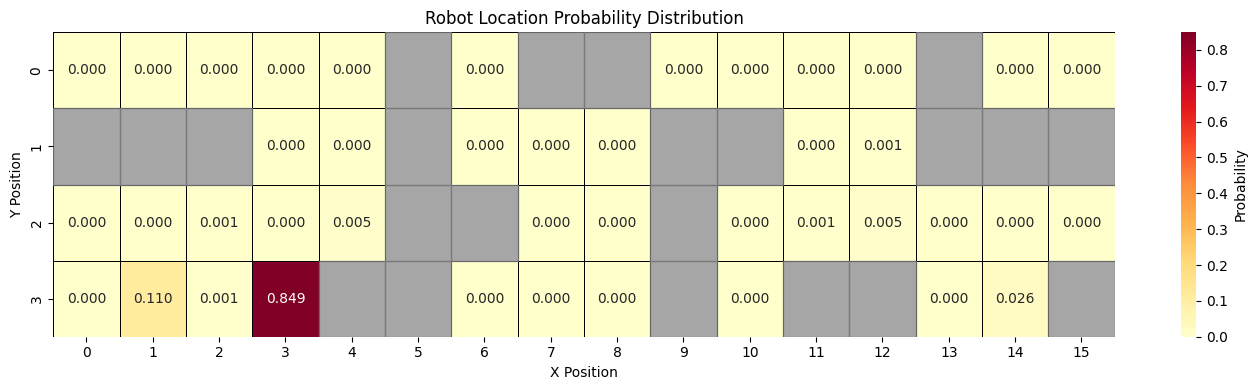

In [15]:
view_heatmap(filtering(E, O, T, X0), S)

Check the contents of the variable `path`. If there is a reasonable amount of measurements as evidence, the probability of the last element should be the highest. Verify that by running the next cell.

In [16]:
path

[(13, 3),
 (13, 2),
 (14, 2),
 (13, 2),
 (14, 2),
 (15, 2),
 (14, 2),
 (14, 3),
 (13, 3),
 (14, 3)]

## Smoothing

As for **smoothing**, we can use it to infer a past state given a set of measurements: that is, we wish to obtain $P(X_j|E_{1:k}=e_{1:k})$, $1\leq j<k$. Supply some evidence and run the `smoothing` function. Check that what the functions returns makes sense.

In [17]:
def smoothing(E, O, T, X0, k):
    
    """
    Perform smoothing using the Forward-Backward algorithm to estimate the probability distribution 
    over states given a sequence of measurements, incorporating both past and future evidence with respect
    to step time k.

    Parameters:
    - E (list): List of binary measurements obtained at each time step.
    - O (dict): Dictionary of observation matrices for different binary measurements.
    - T (numpy.ndarray): Transition matrix representing the probabilities of transitioning between states.
    - X0 (numpy.ndarray): Initial probability distribution over states.
    - k (int): Time step at which to perform smoothing.

    Returns:
    - smooth (numpy.ndarray): Estimated probability distribution over states at time step k, 
                             considering both past and future evidence.
    """
    
    forward = filtering(E[:k], O, T, X0)
    
    backward = np.ones((T.shape[0],1))
    
    for evidence in E[-1:k-1:-1]:
        backward = T @ O[evidence] @ backward
    
    smooth = forward * backward
    smooth = smooth / smooth.sum()
    
    return smooth

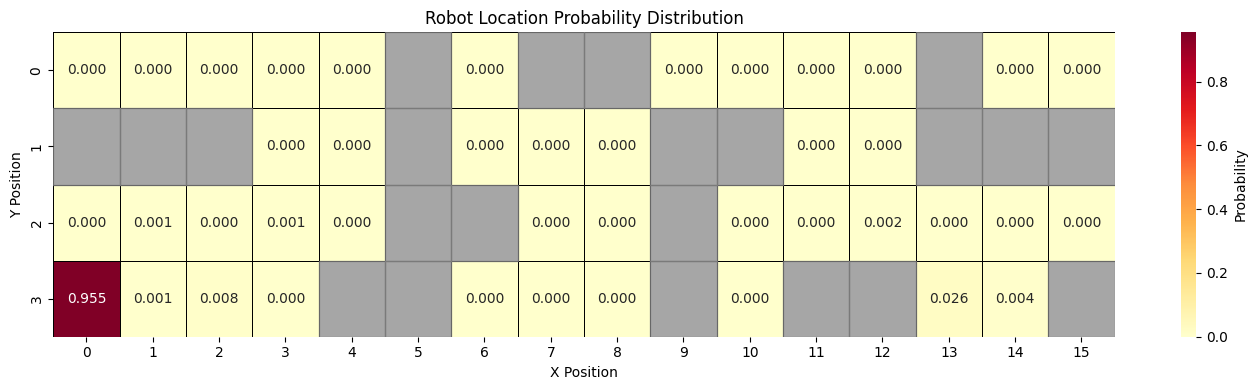

In [18]:
view_heatmap(smoothing(E, O, T, X0, 1), S)

Check the contents of the `path` variable again. If there is a reasonable number of measurements as evidence, the probability of the kth element should be the highest. Check this by executing the next cell.

In [19]:
path

[(13, 3),
 (13, 2),
 (14, 2),
 (13, 2),
 (14, 2),
 (15, 2),
 (14, 2),
 (14, 3),
 (13, 3),
 (14, 3)]

## Most Likely Sequence of States

Finally, for obtaining the most likely sequence that produced the given evidence, we need to compute

$$
\max_{x_{1:k}}P(x_{1:k}|E_{1:k}=e_{1:k}).
$$

As it was mentioned in class, the most likely sequence is the one that has the highest probability, which is obtained by the **Viterbi algorithm**. 

For this part of the assignment, pick a path in advance and record the set of measurements the robot would take along the road. Do not forget to include the possibility of getting some incorrect measurements in this process.

In [20]:
def most_likely_sequence(E, O, S, T, X0):
    
    """
    This function finds the most likely sequence of states given a sequence of measurements using the 
    Viterbi algorithm.

    Parameters:
    - E (list): List of binary measurements obtained at each time step.
    - O (dict): Dictionary of observation matrices for different binary measurements.
    - S (list): List of state names or indices.
    - T (numpy.ndarray): Transition matrix representing the probabilities of transitioning between states.
    - X0 (numpy.ndarray): Initial probability distribution over states.

    Returns:
    - best_sequence (list): Most likely sequence of states corresponding to the given sequence of measurements.
    """
    
    sequences = np.zeros((T.shape[0], len(E)))
    states = np.zeros((T.shape[0], len(E)))
    ones = np.ones((T.shape[0], T.shape[0]))
    sequences[:, 0] = (O[E[0]] @ X0).reshape((T.shape[0],))
    message = sequences[:, 0].reshape((T.shape[0], 1))
    
    for i, evidence in enumerate(E[1:]):
        message = (T @ O[evidence]) * (message * ones)
        states[:, i+1] = np.argmax(message, axis=0).reshape((T.shape[0],))
        message = np.max(message, axis=0).reshape((T.shape[0], 1))
        sequences[:, i+1] = message.reshape((T.shape[0],))
        
    states = states.astype('int32')
    s = np.argmax(sequences[:, -1], axis=0)
    best_sequence = [S[s]]
    
    for i in range(len(E)-1, 0, -1):
        s = states[s, i]
        best_sequence.append(S[s])
        
    best_sequence = best_sequence[::-1] 
    
    return best_sequence

In [21]:
sequence = most_likely_sequence(E, O, S, T, X0)
sequence

[(0, 3),
 (0, 2),
 (1, 2),
 (2, 2),
 (1, 2),
 (1, 3),
 (1, 2),
 (1, 3),
 (2, 3),
 (3, 3)]

Compare the sequence of states obtained after calling the `most_likely_sequence` function with the actual path followed by the robot. Ignoring the initial position of the robot, i.e. the initial state, all the locations stored in the variable `sequence` should be the same as those stored in the variable `path`.

In [22]:
path

[(13, 3),
 (13, 2),
 (14, 2),
 (13, 2),
 (14, 2),
 (15, 2),
 (14, 2),
 (14, 3),
 (13, 3),
 (14, 3)]

For visualization purposes, define a vector of 42 components in which the entry associated to a state that belongs to the most likely sequence is set to one, otherwise, set the entry to zero. Call the `view_heatmap` function, which should receive the vector that you just defined as an input, and obtain the corresponding heatmap. The shown path should be the sequence of locations that the robot occupied.

In [23]:
"""
You will have to write some code here for computing your vector of zeros and ones. Store this information
as "vector".
"""

vector = np.zeros((len(S), 1))

# Create a reverse mapping from location to state index
location_to_state = {loc: idx for idx, loc in S.items()}

# Mark states that belong to the most likely sequence
for location in sequence:
    if location in location_to_state:
        state_idx = location_to_state[location]
        vector[state_idx] = 1

print(f"Number of states in most likely sequence: {int(vector.sum())}")
print(f"Sequence locations: {sequence}")

Number of states in most likely sequence: 7
Sequence locations: [(0, 3), (0, 2), (1, 2), (2, 2), (1, 2), (1, 3), (1, 2), (1, 3), (2, 3), (3, 3)]


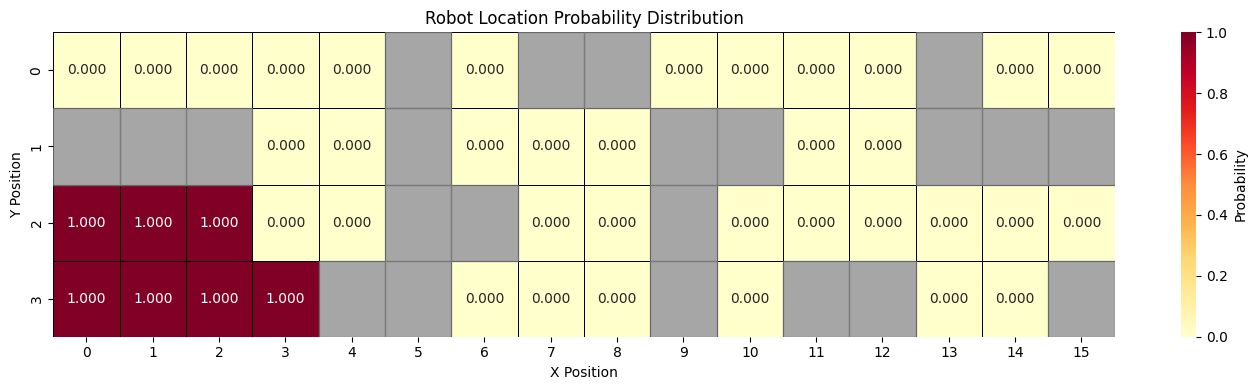

In [24]:
view_heatmap(vector, S)